In [1]:
from IPython.display import display, HTML

import sys

from pyspark import SparkConf, SparkContext, SQLContext
import matplotlib.pyplot as plt
import numpy
import geopandas
import pandas
import geopy
import seaborn as sns

In [2]:
conf = SparkConf().setAppName("HackTheMachineDataProcess")
conf = conf.setMaster("local[*]")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [32]:
df = sqlContext.read\
                .format("csv")\
                .options(header="true", inferSchema="true")\
                .load("/srv/scratch/hackthemachine/data/AIS_ASCII_by_UTM_Month/2015/AIS_2015_01_Zone10.csv")

In [33]:
df.printSchema()

root
 |-- MMSI: integer (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: integer (nullable = true)



In [34]:
df[["MMSI", "BaseDateTime", "LAT", "LON", "SOG", "COG", "VesselType"]].limit(5).toPandas()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselType
0,367013050,2015-01-01 00:00:17,47.64809,-122.35087,4.4,117.5,1012.0
1,367436210,2015-01-01 00:02:17,46.19725,-123.80085,0.0,-95.9,0.0
2,367492890,2015-01-01 00:02:28,47.82257,-122.47040,8.6,165.7,1001.0
3,367350050,2015-01-01 00:02:49,37.81690,-122.40924,8.5,-85.9,1012.0
4,316013431,2015-01-01 00:03:33,48.41467,-123.38626,0.0,-94.2,NaN


In [6]:
#from pyspark.sql.functions import when, lit, col
#import math

#def latNormalizeUDF(lat):
#    return (lat + 90) / 180.

#def lonNormalizeUDF(lon):
#    return (lon + 180) / 360.

#def headingNullifyUDF(heading):
#    return when(heading != 511, heading).otherwise(lit(None))

#def headingNormalizeUDF(heading):
#    return when(heading == math.nan, heading).otherwise(heading / 360.)

#def sogNormalizeUDF(sog):
#    return sog / 102.

#df = df.withColumn("LAT", latNormalizeUDF(df.LAT))\
#        .withColumn("LON", lonNormalizeUDF(df.LON))\
#        .withColumn("SOG", sogNormalizeUDF(df.SOG))\
#        .withColumn("Heading", headingNormalizeUDF(headingNullifyUDF(df.Heading)))

In [7]:
df.limit(5).toPandas()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,367013050,2015-01-01 00:00:17,0.764712,0.160136,0.043137,117.5,NaN,GOODTIME III,None,WSX5383,1012.0,under way using engine,22.22,7.30,0.00,0.0
1,367436210,2015-01-01 00:02:17,0.756651,0.156109,0.000000,-95.9,0.677778,ELTON,None,WDF3125,0.0,moored,20.00,8.00,0.00,0.0
2,367492890,2015-01-01 00:02:28,0.765681,0.159804,0.084314,165.7,0.461111,ISLAND TRADER,None,WDF8244,1001.0,at anchor,26.12,8.60,0.00,30.0
3,367350050,2015-01-01 00:02:49,0.710094,0.159974,0.083333,-85.9,NaN,ALCATRAZ CLIPPER,None,WDE4199,1012.0,under way using engine,38.83,10.50,0.00,NaN
4,316013431,2015-01-01 00:03:33,0.768970,0.157260,0.000000,-94.2,0.686111,PACIFIC SCOUT,None,None,NaN,undefined,19.00,6.06,2.88,50.0


In [8]:
df.count()

24365416

In [9]:
df = df.filter(df.SOG > (0 - (2/102.)))

In [10]:
df.count()

24365277

In [11]:
some_data = df.limit(50000).toPandas()

In [ ]:
sns.pairplot(x_vars=["LON"], y_vars=["LAT"], data=some_data, hue="VesselType", 
             size=8, plot_kws={'alpha':0.25})
plt.show()

In [ ]:
df.select("Heading").toPandas().hist()
df.select("SOG").toPandas().hist()
plt.show()

In [ ]:
from pyspark.sql.functions import desc, asc
df.groupby("MMSI_1").count().sort(desc("count")).toPandas()

In [12]:
from mpl_toolkits.basemap import Basemap

In [13]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5)

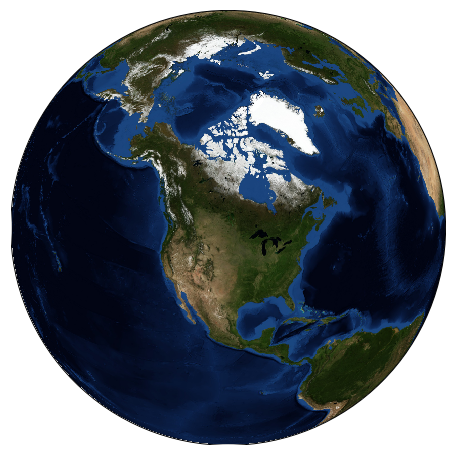

In [17]:
lats = (some_data["LAT"] * 180) - 90
lons = (some_data["LON"] * 360) - 180

coords = zip(lats, lons)
for coord in coords:
    x, y = m(coord[0], coord[1])
    plt.plot(x, y, 'ok', markersize=2)
    
plt.show()

In [31]:
bm = Basemap()
print("In the sound: " + str(bm.is_land(47.64809, -122.35087)))
print("On land: " + str(bm.is_land(48.8717, -120.7079)))

In the sound: False
On land: False


In [ ]:
df.groupby("MMSI").count().sort(desc("count")).toPandas()

# Data with latest timestamp and COG and SOG

In [66]:
from pyspark.sql.functions import desc, asc
processed = df.rdd
time_proc = processed.map(lambda x: (x.MMSI, x.BaseDateTime, x.LAT, x.LON, x.SOG, x.COG, x.Heading, x.Status))\
        .groupBy(lambda x: x[0])
time_proc.take(5)

[(256804000, <pyspark.resultiterable.ResultIterable at 0x7ff369f6e668>),
 (308275000, <pyspark.resultiterable.ResultIterable at 0x7ff3623b32e8>),
 (316005175, <pyspark.resultiterable.ResultIterable at 0x7ff361fb92b0>),
 (316020175, <pyspark.resultiterable.ResultIterable at 0x7ff36047d080>),
 (367102950, <pyspark.resultiterable.ResultIterable at 0x7ff36047d0b8>)]

In [68]:
list(time_proc.take(1)[0][1])

[(256804000,
  datetime.datetime(2015, 1, 1, 0, 1, 40),
  49.28926,
  -123.06747,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 10, 42),
  49.28929,
  -123.06749,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 7, 40),
  49.28932,
  -123.06751,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 13, 43),
  49.28929,
  -123.0675,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 16, 43),
  49.28928,
  -123.06748,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 19, 43),
  49.28929,
  -123.06747,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 22, 44),
  49.28927,
  -123.06749,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1, 0, 28, 40),
  49.28929,
  -123.06749,
  0.0,
  69.9,
  181.0,
  'moored'),
 (256804000,
  datetime.datetime(2015, 1, 1

In [69]:
time_proc_sort = time_proc.map(lambda x: (x[0], sorted(x[1], key=lambda y: y[1])))
time_proc_sort.take(1)

[(256804000,
  [(256804000,
    datetime.datetime(2015, 1, 1, 0, 1, 40),
    49.28926,
    -123.06747,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2015, 1, 1, 0, 7, 40),
    49.28932,
    -123.06751,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2015, 1, 1, 0, 10, 42),
    49.28929,
    -123.06749,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2015, 1, 1, 0, 13, 43),
    49.28929,
    -123.0675,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2015, 1, 1, 0, 16, 43),
    49.28928,
    -123.06748,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2015, 1, 1, 0, 19, 43),
    49.28929,
    -123.06747,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2015, 1, 1, 0, 22, 44),
    49.28927,
    -123.06749,
    0.0,
    69.9,
    181.0,
    'moored'),
   (256804000,
    datetime.datetime(2

In [73]:
time_proc_sort_filter = time_proc_sort.filter(lambda x: len(x[1]) >=3)

In [74]:
final = time_proc_sort_filter.map(lambda x: (x[1][-1], x[1][-2], x[1][-3]))
final.take(5)

[((306258000,
   datetime.datetime(2015, 1, 31, 23, 58, 47),
   47.61352,
   -122.35434,
   0.0,
   52.6,
   87.0,
   'moored'),
  (306258000,
   datetime.datetime(2015, 1, 31, 23, 55, 46),
   47.61352,
   -122.35434,
   0.0,
   -151.1,
   86.0,
   'moored'),
  (306258000,
   datetime.datetime(2015, 1, 31, 23, 52, 46),
   47.61351,
   -122.35435,
   0.0,
   -128.2,
   87.0,
   'moored')),
 ((316005925,
   datetime.datetime(2015, 1, 26, 18, 55, 16),
   48.66895,
   -123.40485,
   0.0,
   -49.6,
   152.0,
   None),
  (316005925,
   datetime.datetime(2015, 1, 26, 18, 52, 16),
   48.66895,
   -123.40485,
   0.0,
   -49.6,
   153.0,
   None),
  (316005925,
   datetime.datetime(2015, 1, 26, 18, 49, 16),
   48.66895,
   -123.40485,
   0.0,
   -49.6,
   152.0,
   None)),
 ((319774000,
   datetime.datetime(2015, 1, 31, 23, 58, 57),
   37.79025,
   -122.29229,
   0.0,
   -104.9,
   257.0,
   'moored'),
  (319774000,
   datetime.datetime(2015, 1, 31, 23, 55, 57),
   37.79028,
   -122.29227,
   0.

In [75]:
final_local = final.collect()

In [76]:
import pickle
pickle.dump(final_local, open("/srv/scratch/hackthemachine/spark_outputs/sorted_sog_cog_data.pkl", "wb"))

In [77]:
final.count()

3598

In [81]:
time_proc_sort_filter.map(lambda x: len(x[1])).stats()

(count: 3598, mean: 6771.843246247916, stdev: 9246.468976717933, max: 40596.0, min: 3.0)